# Salary Analysis & Predictions Based on Job Descriptions
***

## Table of Contents

### Part 1 - DEFINE
#### 1, Define the problem
- [Why is over spending on new hires a problem?](#problem)

### Part 2 - DISCOVER
#### 2. Load the data
#### 3. Clean the data
- [Inspection of data: Missing values, data types, duplicates, summary statistics](#datacleaning)

#### 4. Explore the data (EDA)
- [Correlation Matrix](#correlation_matrix)
- [Distribution plots of numeric features](#distplots)
- [Plots of numeric features and target](#numplots)
- [Average salary across categorical features](#average)
- [Boxplots of categorical features and target](#boxplots)
- [Bargraphs to examine relationship between categorical features](#bar)

#### 5. Establish a baseline
- [Calculating MSE using average salary as the predicted value](#baseline)

#### 6. Hypothesize solutions


### Part 3 - DEVELOP
#### 7. Engineer features
- [Dropping features](#drop)
- [Converting categorical features into numeric](#cattonum)
- [Splitting data into training and testing sets](#split)

#### 8. Create & test models
- [Linear Regression with interaction effects](#lr)
- [Random Forest](#rf)

#### 9. Select best model

### Part 4 - DEPLOY
#### 10. Automate pipeline
- [Engineer features, train, and test model](#automate)

#### 11. Deploy solution
- [Saving predictions as csv and reaching out to finance team](#deploy)
- [Analysis on predicted salary](#analysis)

### Part 5 - Actionable recommendations
- [Budget allocation based on company and job requirements](#rec)
***

A dataset of job descriptions, candidates degrees, major, years of experience, miles away from city, and salaries is collected and we will achieve the following objectives by exploring the dataset.

## Objective
- To understand how much a new hire should be paid.

- To understand characteristics of higher vs lower salaries.

- To create a model that predicts the salary of a new hire based on job descriptions. 

- To allocate budget for new hires and adjust qualifications based on budget. 

The implementation of this model will allow management to allocate budget for new hires to avoid underpaying or overpaying them.

## We'll be covering
1. Descriptive Analytics - What happened?
2. Predictive Analytics - What might happen?
3. Prescriptive Analytics - What should we do?
***

# Part 1 - DEFINE

<a id='problem'></a>
### 1. Define the problem

Companies often face a problem of **over spending** on new hires, whereby they spend more money than they have to hire new people. Over spending would negatively impact the financial health of the company and result in decreased profit, debts, and even bankcruptcy if uncontrolled. 

Imagine that a company spends **500,000 dollars** on new hires annually when it has **200,000 dollars**. The company incurs a deficit of **300,000 dollars**. The company can avoid over spending by knowing how much new hires are going to cost, and compare the cost with what they have, to determine who and how many people they can hire.



### An example

For example, a company wants to hire 2 Software Engineers and a Director of Data Science. An entry-level Software Engineer will cost about 125,000 dollars and a Director of Data Science with 10+ years of experience will cost about 250,000 dollars. The company will need to allocate **500,000 dollars.** 

((125,000 * 2) + 250,000) =  500,000

If the company only has **200,000 dollars**, then it could only afford to hire an entry-level Software Engineer or an Associate Director of Data Science that is within budget. 

In [1]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
%matplotlib inline

__author__ = "Janice Tjeng"
__email__ = "janicetjeng@gmail.com"

***
## Part 2 - DISCOVER

### 2. Load the data

In [2]:
# Importing the data
salary_features = pd.read_csv("./data/train_features.csv")
salary = pd.read_csv("./data/train_salaries.csv")

In [3]:
salary_features.shape

(1000000, 8)

In [4]:
salary.shape

(1000000, 2)

The number of rows in the features and target data sets match, so they will be combined for further sanity checks and analysis

In [5]:
# Combine both data sets
salary_combined = salary_features.join(salary.set_index("jobId"),how="inner",on="jobId")

<a id='datacleaning'></a>
### 3. Clean the data

In [6]:
# Look for missing values
salary_combined.isnull().any()

jobId                  False
companyId              False
jobType                False
degree                 False
major                  False
industry               False
yearsExperience        False
milesFromMetropolis    False
salary                 False
dtype: bool

In [7]:
# Check that type of features are consistent with they should be
salary_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [8]:
# Look for duplicate values
print("Number of duplicated records in training set: ", salary_combined.duplicated().sum())

Number of duplicated records in training set:  0


In [9]:
# Summarizing data with descriptive statistics to look for invalid data
salary_combined.describe()

,yearsExperience,milesFromMetropolis,salary
count,1000000.000000,1000000.000000,1000000.000000
mean,11.992386,49.529260,116.061818
std,7.212391,28.877733,38.717936
min,0.000000,0.000000,0.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


Features do not appear to be highly skewed as mean and median (50th percentile) are similar. However, we will need to investigate jobs with minimum salary of 0.

In [10]:
# Checking for rows with salary of 0
salary_combined[salary_combined.salary==0]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


Executive positions and doctoral degree should not have a salary of 0. It is possible that there are errors in data collection, and removing these data points would not bias our results as they constitute a small amount of observations (5 out of 1,000,000).

In [11]:
# Removing rows with salary of 0
salary_new = salary_combined[salary_combined.salary>0]

In [12]:
# Verify that data points have been removed and there should be 5 rows less than the original
salary_new.shape[0] == salary_combined.shape[0]-5

True


### 4. Explore the data (EDA)

<a id='correlation_matrix'></a>
#### Correlation matrix

In [13]:
# Function for correlation plot
def corr_mat(data):
    corr = data.corr()
    sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
    plt.title('Heatmap of Correlation Matrix')
    return (corr)

,yearsExperience,milesFromMetropolis,salary
yearsExperience,1.000000,0.000672,0.375013
milesFromMetropolis,0.000672,1.000000,-0.297686
salary,0.375013,-0.297686,1.000000


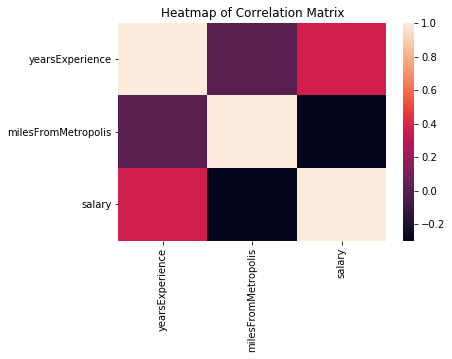

In [14]:
corr_mat(salary_new)

Salary is negatively correlated with miles from metropolis, the further the jobs are away from the city, the lower the salaries. 

Salary is positively correlated with years of experience, as jobs require people with more experience, salaries increase. 

There is a weak correlation between years of experience and miles from metropolis, the number of years of experience a job requires is not determined by where its located. 

<a id='distplots'></a>
#### Distribution plots

In [15]:
# Function to visualize distribution of numerical features
def plot_num(data,size):
    num_vars = data.select_dtypes(exclude=["object"]).columns
    plt.figure(figsize=size)
    for i in range(len(num_vars)):
        plt.subplot(3,3,i+1)
        sns.distplot(salary_new[num_vars[i]])

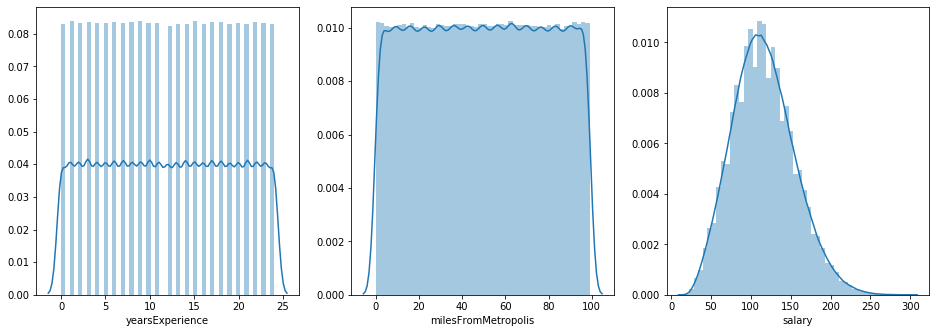

In [16]:
plot_num(salary_new,(16,18))

Salary follows a close to normal distribution, implying that a most of the jobs pay close to the average salary, with equally few jobs that are extremely low and high paying. On the other hand, years of experience and miles from metropolis have a uniform distribution, implying that there is an equal number of jobs with varying years of experience and miles away from city.

<a id='numplots'></a>

#### Plots of numeric features against target

*Years of experience and salary*

In [17]:
#Function for pointplot
def point_plot(dat,ind,dep):
    plt.figure(figsize=(10,10))
    sns.pointplot(x=ind,y=dep,data=dat)

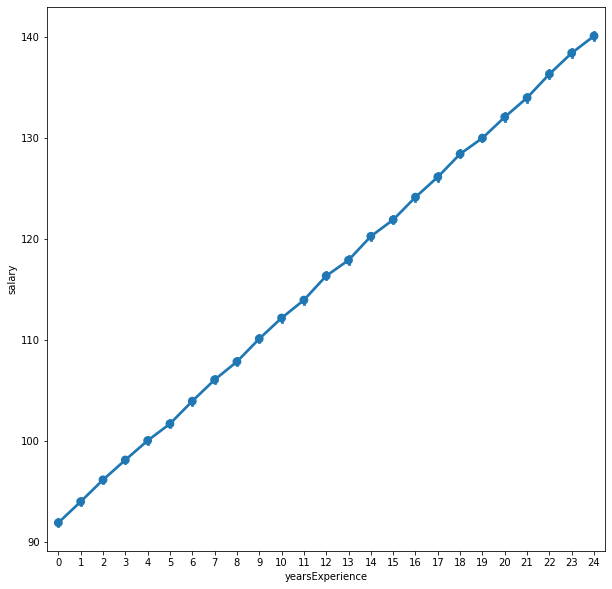

In [18]:
point_plot(salary_new,"yearsExperience","salary")

We can see that salary increases with more years of experience.

*Miles from metropolis and salary*

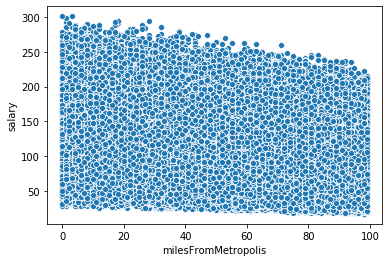

In [19]:
sns.scatterplot(x="milesFromMetropolis", y="salary",data=salary_new)

We can see that salary decreases with increasing miles away from city.

<a id='average'></a>
**Average salary across categorical features**

In [20]:
categorical_var = ["jobType","degree","major","industry"]
for i in range(len(categorical_var)):
    print(salary_new.groupby(categorical_var[i]).mean().reset_index())

          jobType  yearsExperience  milesFromMetropolis      salary
0             CEO        11.998269            49.478458  145.311425
1             CFO        11.990440            49.572715  135.458547
2             CTO        12.010860            49.580847  135.481067
3         JANITOR        11.969657            49.443815   70.813045
4          JUNIOR        11.992383            49.660508   95.333087
5         MANAGER        11.987284            49.498354  115.368518
6          SENIOR        11.996624            49.572558  105.487775
7  VICE_PRESIDENT        11.993700            49.428222  125.368630
        degree  yearsExperience  milesFromMetropolis      salary
0    BACHELORS        11.986045            49.589646  125.454663
1     DOCTORAL        12.003279            49.609020  135.490979
2  HIGH_SCHOOL        11.995519            49.459310  101.921085
3      MASTERS        11.984987            49.554064  130.505647
4         NONE        11.991450            49.477600   98.17688

<a id='boxplots'></a>
**Box plots**

We will create boxplots to visualize categorical features: jobtypes, industry, major, and degree, in relationship with salary


In [21]:
def box_plot(size,categorical_var,dep,dat):
    plt.figure(figsize=size)
    plt.suptitle("Green triangle represents mean",fontsize=16)
    for i in range(len(categorical_var)):
        plt.subplot(2,2,i+1)
        sns.boxplot(x=categorical_var[i],y=dep,data=dat, showmeans=True)
        plt.xticks(rotation=45)
    

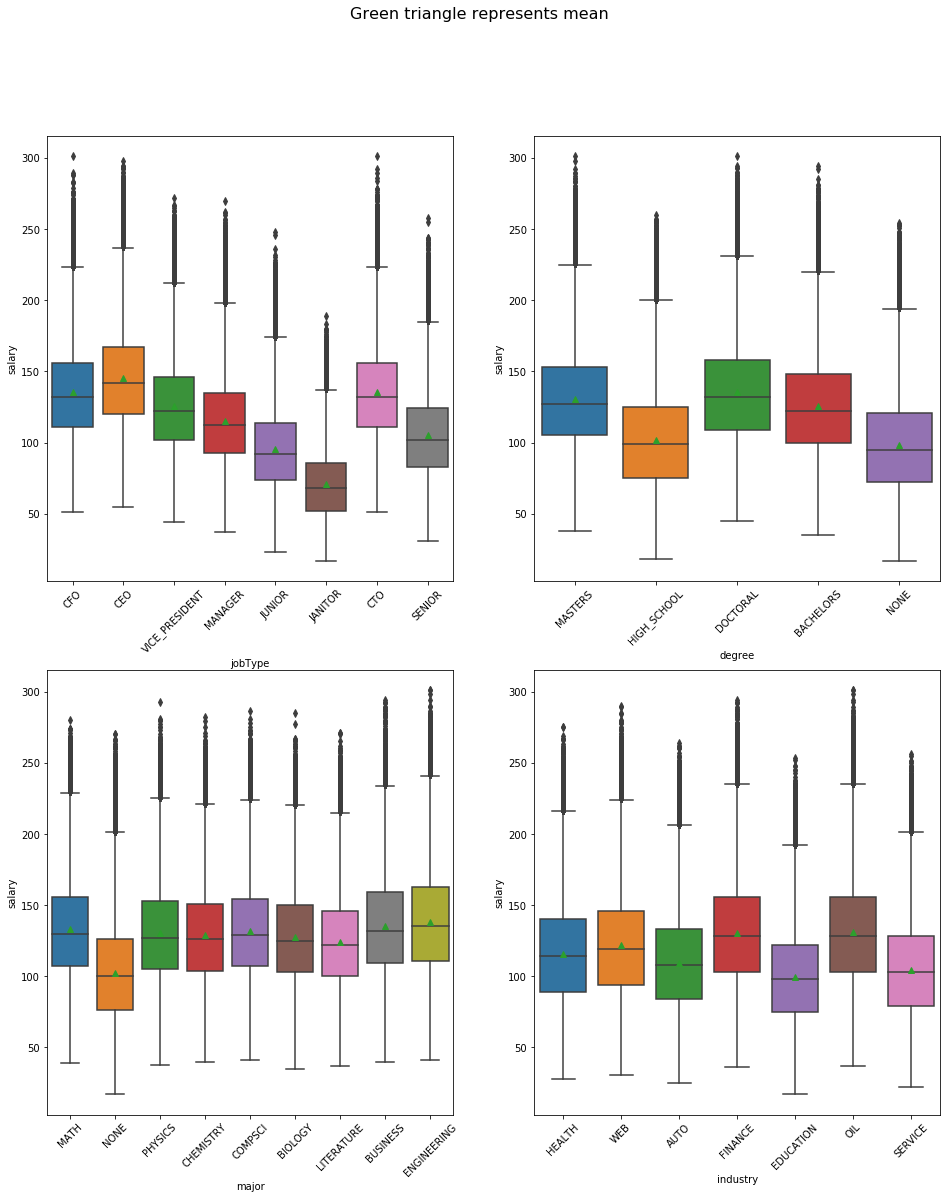

In [22]:
box_plot((16,18),["jobType","degree","major","industry"],"salary",salary_new)

*Job type and average salary*

Executive positions (CFO, CTO, CEO) have the highest average salaries while janitor has the lowest average salary. Senior and manager positions do not have huge difference in average salaries.

*Degree and average salary*

There is not much difference in average salaries between jobs that do not require a degree and those that require a high school degree. Jobs with bachelor's degree requirements have slightly lower average salaries than those with master's and doctoral degree requirements, while the latter have similar average salaries.

*Major and average salary*

Average salaries of different majors are roughly similar, except for jobs that do not require a major that have lower average salaries, which could mean that candidates for these jobs have at most a high school degree, which affect their salaries.

*Industry and salary*

Finance and oil indsutries have higher average pay while service, education, and auto industries have lower average pay.

<a id='bar'></a>
**Bar graphs**

*Degree and job type*

In [23]:
# Function to plot bar graphs
def plot_bar(ind,dep,grp,h,a,dat):
    sns.catplot(x=ind,y=dep,hue=grp,kind="bar",height=h,aspect=a,data=dat)
    plt.xticks(rotation=45)

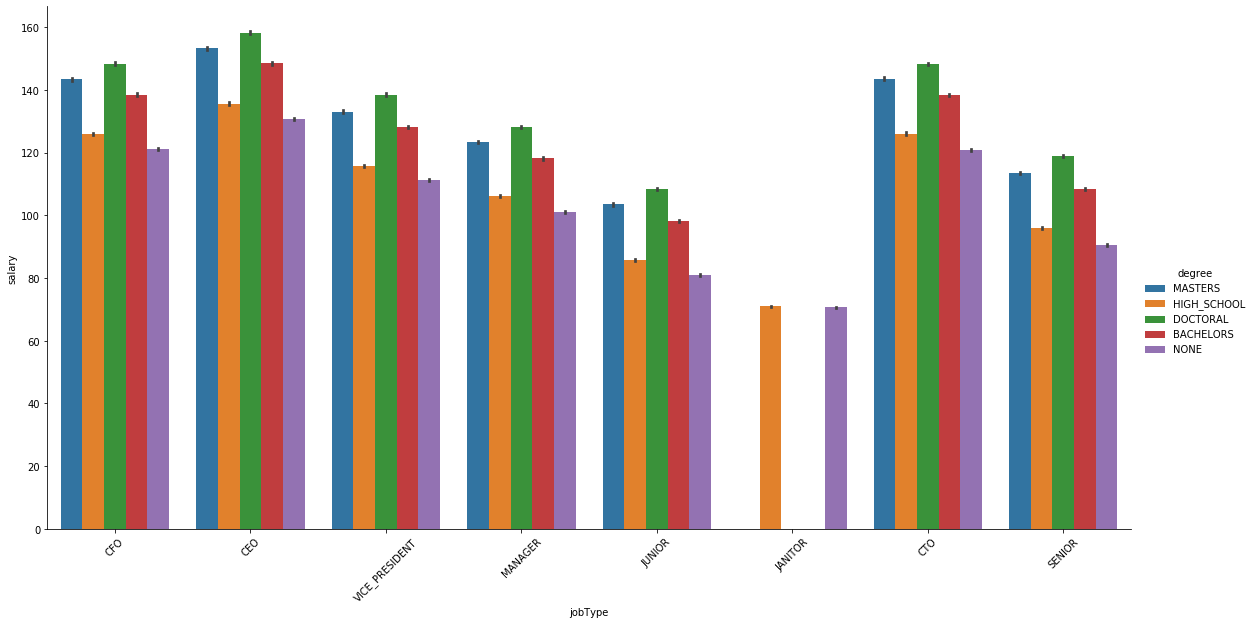

In [24]:
plot_bar("jobType","salary","degree",8,2,salary_new)

Apart from janitor positions that do not require more than a high school degree, other positions have a variety of different degrees, which means that jobs require at least a bachelor's degree for a junior position, but jobs with higher level positions do not necessarily require more advanced degreea.

*Degree and major*

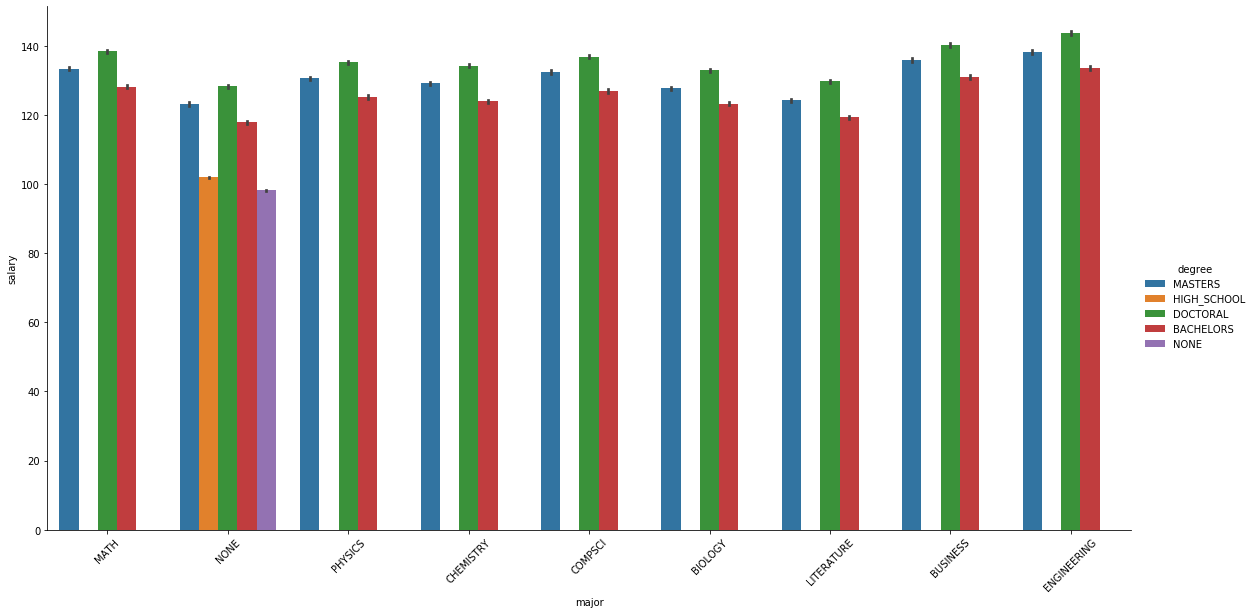

In [25]:
plot_bar("major","salary","degree",8,2,salary_new)

We would hypothesize that a major would indicate at least a bachelors degree, which is confirmed in the plot above. However, there are jobs without a major but have degrees. Candidates for these jobs could either did not declare a major or there is missing data (major is not listed in the application drop down menu). Let's inspect these candidates.

In [26]:
salary_combined[salary_combined.major=="NONE"]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
6,JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24,178
8,JOB1362684407695,COMP20,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,54,31
10,JOB1362684407697,COMP56,JANITOR,HIGH_SCHOOL,NONE,HEALTH,24,30,102
12,JOB1362684407699,COMP4,JUNIOR,NONE,NONE,OIL,8,29,79
...,...,...,...,...,...,...,...,...,...
999991,JOB1362685407678,COMP22,VICE_PRESIDENT,NONE,NONE,WEB,22,48,139
999996,JOB1362685407683,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35,160
999997,JOB1362685407684,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64
999998,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149


Since there are more than 50% of jobs that do not have a major but have degrees, we will keep the data as such. From the boxplots, we see that there is not huge differences in salaries across different majors (except for jobs without a major), but the differences are also captured in the relationship between salary and degree. Therefore, we might consider dropping the major variable and only keeping the degree variable when predicting salary.

*Degree and industry*

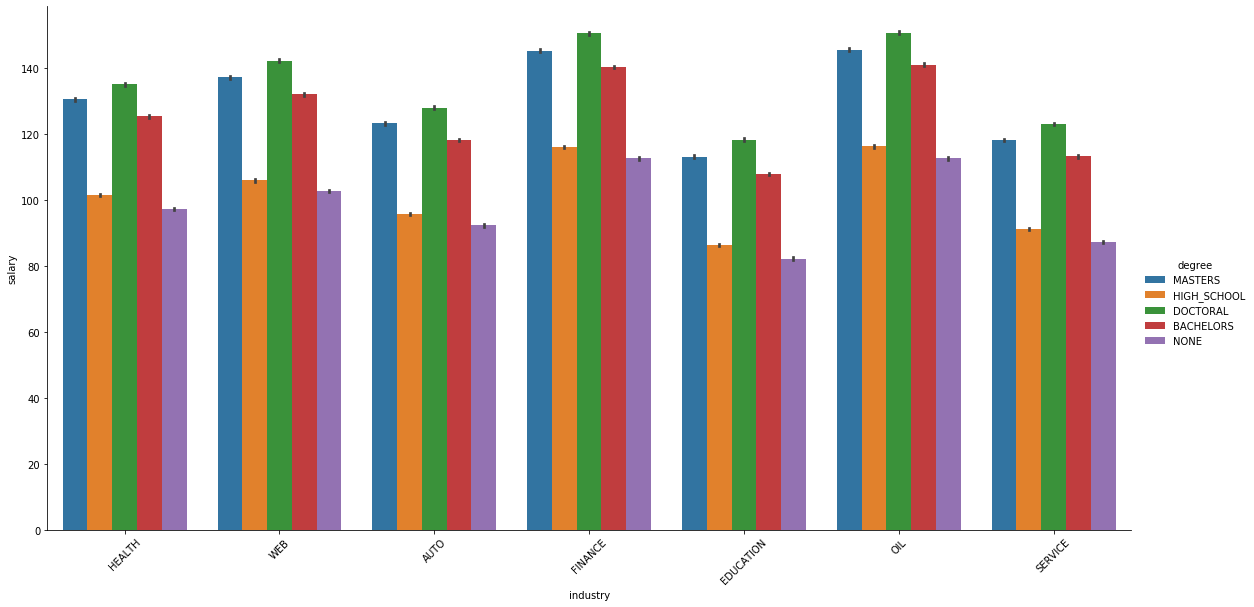

In [27]:
plot_bar("industry","salary","degree",8,2,salary_new)

There is no relationship between degree and industry as different types of degree is seen in all industries.

*Major and industry*

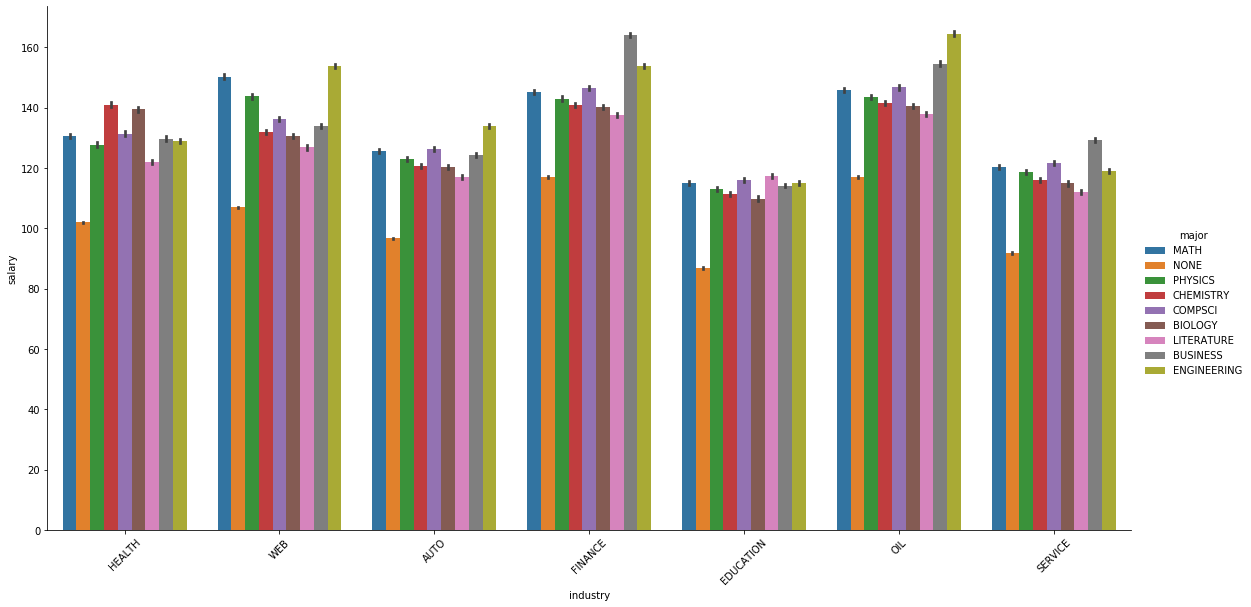

In [28]:
plot_bar("industry","salary","major",8,2,salary_new)

There is no relationship between major and industry as all majors are distributed across all indsutries.

*Major and job type*

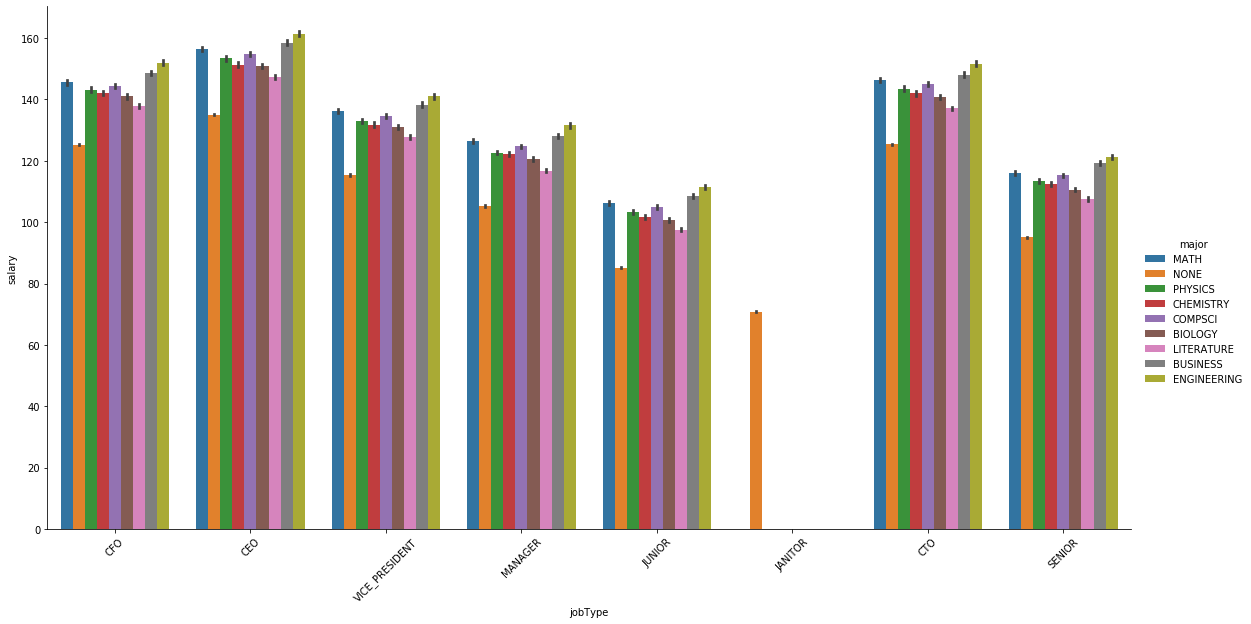

In [29]:
plot_bar("jobType","salary","major",8,2,salary_new)

Apart from janitor positions that do not require bachelor's degree or above (hence no major), other positions have a variety of different majors. 

*Industry and job type*

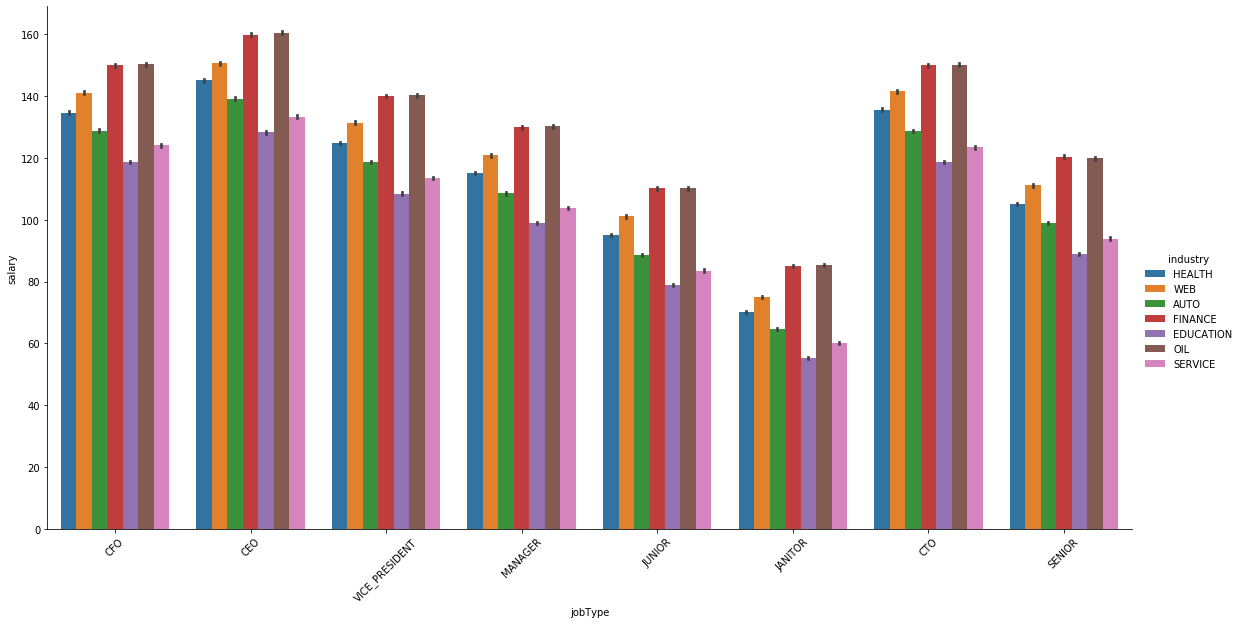

In [30]:
plot_bar("jobType","salary","industry",8,2,salary_new)

There is no relationship between job type and industry as different industries are distributed across all types of job.


<a id='baseline'></a>
### 5. Establish a baseline

Since there is noticeable variation in salary for different job types, we will use the average salary for each job type as the predicted salary and calculate MSE to establish our baseline. The models that we will be built need to have lower MSE than the baseline.

In [32]:
mean_job_type = salary_new.groupby("jobType").mean().reset_index()
mean_job_type.drop(columns=["yearsExperience","milesFromMetropolis"],inplace=True)

In [33]:
mean_job_type

,jobType,salary
0,CEO,145.311425
1,CFO,135.458547
2,CTO,135.481067
3,JANITOR,70.813045
4,JUNIOR,95.333087
5,MANAGER,115.368518
6,SENIOR,105.487775
7,VICE_PRESIDENT,125.368630


In [34]:
pred_bs = salary_new.join(mean_job_type.set_index(["jobType"]),on="jobType",how="left",rsuffix="predicted")

In [36]:
def mse(obs,pred):
    total = 0
    for i in range(len(obs)):
        delta = (obs[i]-pred[i])**2
        total += delta
    return total/(len(obs))   

In [37]:
mse_baseline = mse(pred_bs.salary.values,pred_bs.salarypredicted.values)

In [38]:
mse_baseline

963.9252996562875


### 6. Hypothesize solutions

Based on the EDA, features such as job type, degree, miles from metropolis, and years of experience are correlated with salary. 

In terms of relationship among features, degree is related to major, but as mentioned in the EDA, the relationship of degree and major with respect to salary is captured in the degree variable, hence major variable will not be considered when predicting salary. There is a relationship between degree and job type only to the extent that jobs require at least a bachelor's degree for a junior position, but jobs with highler level positions do not necessarily require more advanced degrees.

Because the target variable is normally distributed and there is some correlation among features, a **Linear Regression model with interaction effects** would be appropriate. Furthermore, a linear regression model is easily interpretable and  productionalized at low cost. We will compare the regression approach with **Random Forest**, a tree-based method robust to outliers.

***
## Part 3 - DEVELOP

### 7. Engineer features

<a id='drop'></a>
**Dropping variables**

As mentioned before, we will drop the major variable as the information is captured in the degree variable.

We will also drop the company id and job id as those are identifiers that do not provide meaningful information to predict salary.

In [39]:
salary_featured = salary_new.drop(columns=["major","jobId","companyId"])

<a id='cattonum'></a>

**Converting categorical variables into numeric**

Degree and job type are hierarchical categorical variables, so they can be converted into numeric with a hierarchical order. For example, none degree will be assigned to a value of 0, bachelor's degree assigned to a value of 1, etc.

Industry feature will be coded into dummy variables where each category will be a feature with values 0 or 1 indicating whether or not the particular industry is present. For example, web industry will be a new column with value of 0 if it is absent in the row and 1 if it is present.

In [40]:
# Converting degree into numeric
salary_featured["degree_num"] = np.where(salary_featured.degree=='MASTERS',3,np.where(salary_featured.degree=='HIGH_SCHOOL',1,np.where(salary_featured.degree=='DOCTORAL',4,np.where(salary_featured.degree=='BACHELORS',2,0))))

In [41]:
# Converting jobType into numeric
salary_featured["jobType_num"] = np.where(salary_featured.jobType=='JANITOR',0,np.where(salary_featured.jobType=='JUNIOR',1,np.where(salary_featured.jobType=='SENIOR',2,np.where(salary_featured.jobType=='MANAGER',3,np.where(salary_featured.jobType=='VICE_PRESIDENT',4,np.where(salary_featured.jobType=='CEO',6,5))))))

In [42]:
salary_featured.head()

,jobType,degree,industry,yearsExperience,milesFromMetropolis,salary,degree_num,jobType_num
0,CFO,MASTERS,HEALTH,10,83,130,3,5
1,CEO,HIGH_SCHOOL,WEB,3,73,101,1,6
2,VICE_PRESIDENT,DOCTORAL,HEALTH,10,38,137,4,4
3,MANAGER,DOCTORAL,AUTO,8,17,142,4,3
4,VICE_PRESIDENT,BACHELORS,FINANCE,8,16,163,2,4


In [43]:
# Dummy coding industry feature
dummy = pd.get_dummies(salary_featured["industry"],drop_first=True)
# Combine dummy coding with numerical features
numerical_var = ["yearsExperience","milesFromMetropolis","salary","degree_num","jobType_num"]
new_salary_featured = pd.concat([dummy,salary_featured[numerical_var]],axis=1)

In [44]:
new_salary_featured.head()

,EDUCATION,FINANCE,HEALTH,OIL,SERVICE,WEB,yearsExperience,milesFromMetropolis,salary,degree_num,jobType_num
0,0,0,1,0,0,0,10,83,130,3,5
1,0,0,0,0,0,1,3,73,101,1,6
2,0,0,1,0,0,0,10,38,137,4,4
3,0,0,0,0,0,0,8,17,142,4,3
4,0,1,0,0,0,0,8,16,163,2,4


<a id='split'></a>

**Splitting data into training and testing sets**

In [45]:
# Create the target and feature set
variables = list(new_salary_featured.columns.values)
variables.remove("salary")
features = new_salary_featured[variables]
target = new_salary_featured['salary']

# Define train and test
features_train, features_test, target_train, target_test = train_test_split(features,target,test_size=0.20, random_state=123)

### 8. Create & test models 

<a id='lr'></a>
**Linear regression with interaction effects**

In [50]:
# Modeling interaction of independent variables
interaction = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
# Transforming independent variables in training set based on interaction effect
inter_features = interaction.fit_transform(features_train)
# Transforming independent variables in testing set based on interaction effect
inter_test = interaction.fit_transform(features_test)
# Training linear regression model
reg  = LinearRegression().fit(inter_features,target_train)
# Apply model on test set to predict salary
lr_pred = reg.predict(inter_test)

In [51]:
# R^2 of model
reg.score(inter_features,target_train)

0.7437488273668545

The linear regression model with interaction effects has an R^2 of ~0.74, which means that 74% of variation in salary can be explained by the model.

In [52]:
mse_lr = mse(list(target_test),lr_pred)
mse_lr

382.50389192318664

The model achieves MSE of ~382, which is 60% lower than the baseline.

<a id='rf'></a>
**Random forest**

In [53]:
rf = RandomForestRegressor(random_state=123)

# Define parameters
param_grid = {
                 'n_estimators': [5, 10, 15],
                 'max_depth': [2, 5, 7]
             }

# Perform Grid Search using 5-fold cross validation
grid_obj = GridSearchCV(rf, param_grid, scoring='neg_mean_squared_error')

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(features_train, target_train)

# Get the best estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the best estimator
best_predictions = best_clf.predict(features_test)


In [54]:
mse_rf = mse(list(target_test),best_predictions)
mse_rf

515.8808105464233

Random Forest model achieves MSE of ~516, which is 46% lower than the baseline, but 26% higher than the linear regression model.

<a id='best'></a>
### 9. Select best model 

Since the Linear Regression model has a lower MSE than the Random Forest model, and the former takes up much less computing resources, and is easier to productionalize, we will select the **Linear Regression** model.

***
## Part 4 - DEPLOY

<a id='automate'></a>
### 10. Automate pipeline

We will train the Linear Regression model with interaction effects on the entire data set we have and predict it on the unseen data set.

We will also perform the same feature engineering on our unseen data as we did for our original data set.

In [55]:
# Loading unseen data set
test_salary_features = pd.read_csv("./data/test_features.csv")

In [56]:
# Function to transform features
def feature_engineer(data,dropcols,num_var):
    featured = data.drop(columns=dropcols)
    featured["degree_num"] = np.where(featured.degree=='MASTERS',3,np.where(featured.degree=='HIGH_SCHOOL',1,np.where(featured.degree=='DOCTORAL',4,np.where(featured.degree=='BACHELORS',2,0))))
    featured["jobType_num"] = np.where(featured.jobType=='JANITOR',0,np.where(featured.jobType=='JUNIOR',1,np.where(featured.jobType=='SENIOR',2,np.where(featured.jobType=='MANAGER',3,np.where(featured.jobType=='VICE_PRESIDENT',4,np.where(featured.jobType=='CEO',6,5))))))
    dummy = pd.get_dummies(featured["industry"],drop_first=True)
    new_featured = pd.concat([dummy,featured[num_var]],axis=1)
    return new_featured
    
# Function to train and test the model
def model(features_train,features_test,target_train, deg):
    interaction = PolynomialFeatures(degree=deg, include_bias=False, interaction_only=True)    
    inter_features = interaction.fit_transform(features_train)
    inter_test = interaction.fit_transform(features_test)
    reg  = LinearRegression().fit(inter_features,target_train)
    lr_pred = reg.predict(inter_test)
    return lr_pred

# Function to transform features, train model on transformed data, and test model on unseen data
def pipeline(data,dropcols,num_var,features_train,target_train,deg):
    transformed_data = feature_engineer(data,dropcols,num_var)
    predictions = model(features_train,transformed_data,target_train,deg)
    return predictions


In [57]:
# Generate predictions
dropcols = ["jobId","companyId","major"]
num_var = ["yearsExperience","milesFromMetropolis","degree_num","jobType_num"]
pred = pipeline(test_salary_features,dropcols,num_var,features,target,2)

<a id='deploy'></a>
### 11. Deploy solution

We will save the salary predictions of job descriptions in a csv file so that finance team can analyze and allocate budget for new hires.

We can also do similar analysis on predicted salary along with other features such as jobtype, degree, years of experience, as we did on EDA with known salary to help hiring managers understand trends in higher vs lower paying salaries and adjust hiring requirements and budget accordingly.

In [58]:
# Saving predictions as csv file along with jobId
pred_df = pd.DataFrame({"jobId":test_salary_features.jobId,"salary":pred})
pred_df.to_csv("./data/test_salaries.csv",index=False)

<a id='analysis'></a>

**Analysis on predicted salary**

In [59]:
test_salary_features["salary"] = pred

,yearsExperience,milesFromMetropolis,salary
yearsExperience,1.000000,-0.001141,0.434085
milesFromMetropolis,-0.001141,1.000000,-0.346244
salary,0.434085,-0.346244,1.000000


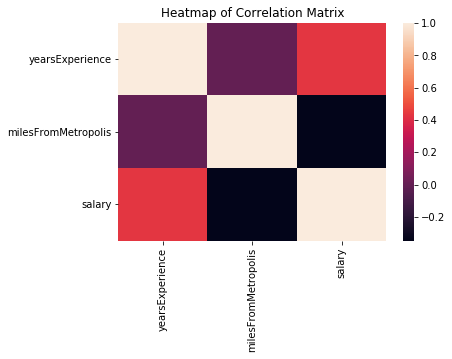

In [60]:
# Visualize correlation matrix
corr_mat(test_salary_features)

Similar to what was observed earlier, salary increases with more years of experience and closer distance to the city.

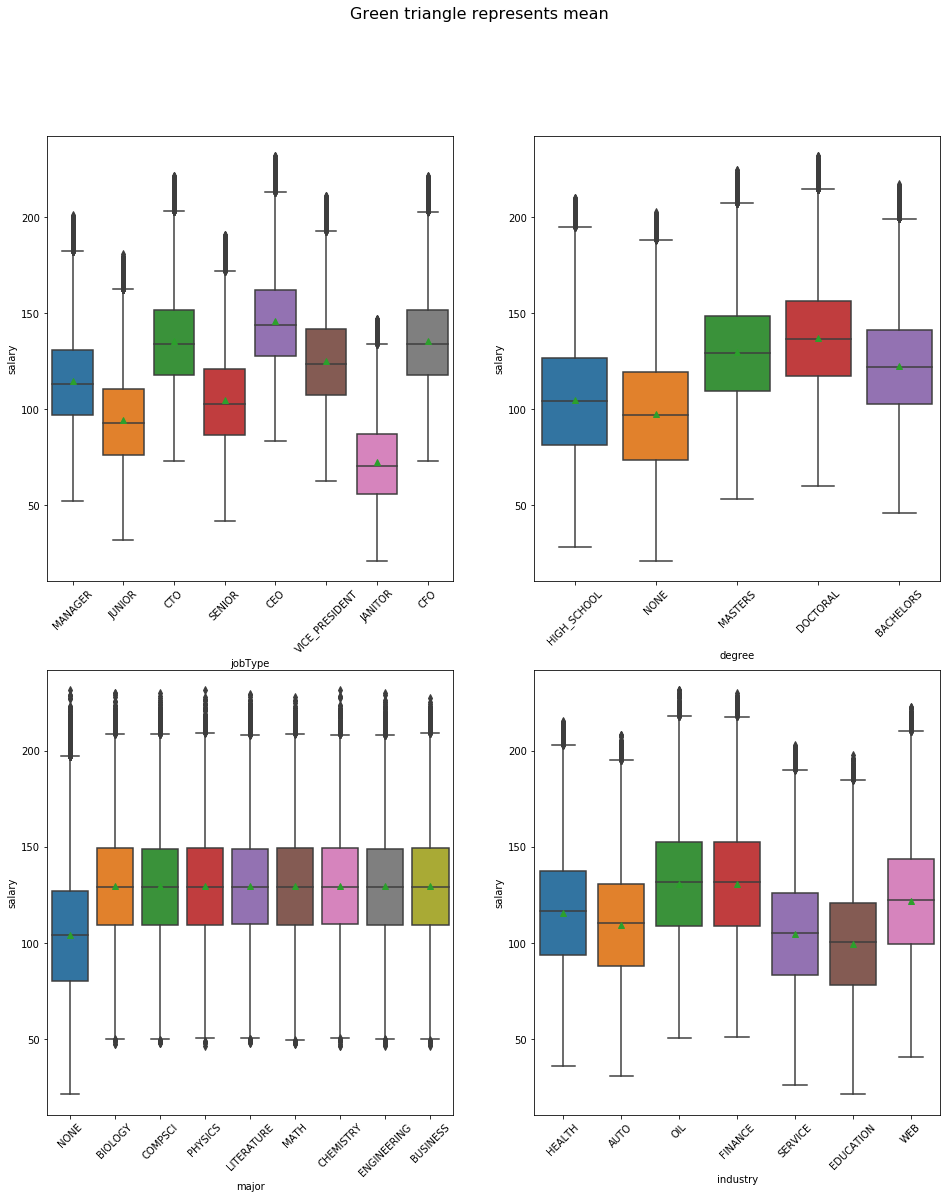

In [61]:
# Visualize jobtype, degree, major, and industry with relation to salary
box_plot((16,18),["jobType","degree","major","industry"],"salary",test_salary_features)

Compared to the known salary, we see a greater variation in job type, degree, and industry with respect to salary

*Job type and salary*

Salary increases as position gets higher. Salary is ordered from low to high in accordance with hierarchical position as such, Janitor < Junior < Senior < Manager < Vice-president < CTO & CFO < CEO

*Degree and salary*

Salary increases with increasing degree such that None < High school < Bachelors < Masters < Doctoral, while the pattern is not as distinct for known salary

*Major and salary*

Candidates with no major have lower salaries than those with majors, such observation is expected as those without major are likely to have no degree, and hence, lower salaries.

*Industry and salary*

We can segment industry and salary into 3 groups: oil and finance industry are high paying, web, health, and auto industry are average paying, while service and education industry are low paying.

***
<a id='rec'></a>
## Part 5 - Actionable recommendations

Depending on the copmany's requirement for new hires, hiring managers might want to consider the job type, degree of candidate, industry, years of experience, and location when allocating budget for new hires. For example, if a company requires a Vice-president level position but have tight budget, hiring managers might consider hiring a competent candidate with a bachelor's degree instead of master's degree.

On the other hand, if a company has excess budget for the same position, hiring managers might consider candidates with advanced degrees.